<a href="https://colab.research.google.com/github/shivani983/computer-vision-handson/blob/main/fire_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!nvidia-smi

Sun Apr 20 04:32:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# cloning yolo v5
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 17410, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 17410 (delta 63), reused 22 (delta 22), pack-reused 17320 (from 3)
Receiving objects: 100% (17410/17410), 16.31 MiB | 15.11 MiB/s, done.
Resolving deltas: 100% (11929/11929), done.


In [26]:
import os
os.chdir("/content/yolov5")

In [27]:
%ls

benchmarks.py    data.yaml   models/          requirements.txt  utils/
CITATION.cff     detect.py   __pycache__/     runs/             val.py
classify/        export.py   pyproject.toml   segment/          yolov5/
CONTRIBUTING.md  hubconf.py  README.md        train.py          yolov5s.pt
data/            LICENSE     README.zh-CN.md  tutorial.ipynb


In [28]:
# installing requirements
!pip install -r requirements.txt
import torch

from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.6.0+cu124 (Tesla T4)


In [29]:
%pwd

'/content/yolov5'

In [30]:
%cd ..

/content


In [31]:
!unzip /content/drive/MyDrive/computervision/fire_detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: Fire-Detection/test/images/2ndfloorFULLYINVOLVEDHelmetCam3007_png.rf.1c14ad0381be6c220aec0faf7896fc45.jpg  
  inflating: Fire-Detection/test/images/2ndfloorFULLYINVOLVEDHelmetCam3265_png.rf.b1d112bb9e742d90d8f6369802c4ea40.jpg  
  inflating: Fire-Detection/test/images/2ndfloorFULLYINVOLVEDHelmetCam3427_png.rf.0a3b10d7bc619eff95b1ab6e2a55404e.jpg  
  inflating: Fire-Detection/test/images/2ndfloorFULLYINVOLVEDHelmetCam4235_png.rf.8ee56b9b501206df36f99fd34295c216.jpg  
  inflating: Fire-Detection/test/images/2ndfloorFULLYINVOLVEDHelmetCam8277_png.rf.623b8f20725ba67edf9b6ab8c60813f7.jpg  
  inflating: Fire-Detection/test/images/ATragicDayFireStormMannford1063_png.rf.6f02c3d0616e168a1c78588c46d93c93.jpg  
  inflating: Fire-Detection/test/images/ATragicDayFireStormMannford1203_png.rf.fc00b4ad1e8c7a86bad844584a8ff8cf.jpg  
  inflating: Fire-Detection/test/images/ATragicDayFireStormMannford1311_png.rf.21ac6a9714da9c6f0e20172e71b23

In [32]:
%cat /content/yolov5/models/yolov5s.yaml

# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 

In [33]:
# customizing iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))



In [36]:
num_classes = 1

yaml_content = f"""
# Parameters

nc: {num_classes}  # number of classes
depth_multiple: 0.33
width_multiple: 0.50
anchors:
  - [10, 13, 16, 30, 33, 23]    # P3/8
  - [30, 61, 62, 45, 59, 119]   # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  [
    [-1, 1, Conv, [64, 6, 2, 2]],
    [-1, 1, Conv, [128, 3, 2]],
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]],
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]],
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]],
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]],
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]],
    [-1, 3, C3, [512, False]],

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]],
    [-1, 3, C3, [256, False]],

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],
    [-1, 3, C3, [512, False]],

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],
    [-1, 3, C3, [1024, False]],

    [[17, 20, 23], 1, Detect, [{num_classes}, anchors]],  # Correct variable usage here
]
"""

with open("/content/yolov5/models/custom_yolov5s.yaml", "w") as f:
    f.write(yaml_content)


In [37]:
%pwd

'/content'

In [38]:
!mv Fire-Detection yolov5/


In [39]:
!echo "train: /content/yolov5/Fire-Detection/train/images" > /content/yolov5/data.yaml
!echo "val: /content/yolov5/Fire-Detection/valid/images" >> /content/yolov5/data.yaml
!echo "nc: 1" >> /content/yolov5/data.yaml
!echo "names: ['fire']" >> /content/yolov5/data.yaml


In [40]:
%pwd

'/content'

In [23]:
cd ..

/content


In [41]:
# training yolov5

%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 30 --data '/content/yolov5/data.yaml' --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results --cache

/content/yolov5
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-04-20 04:34:16.996717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745123657.018270    5709 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745123657.024798    5709 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second tim

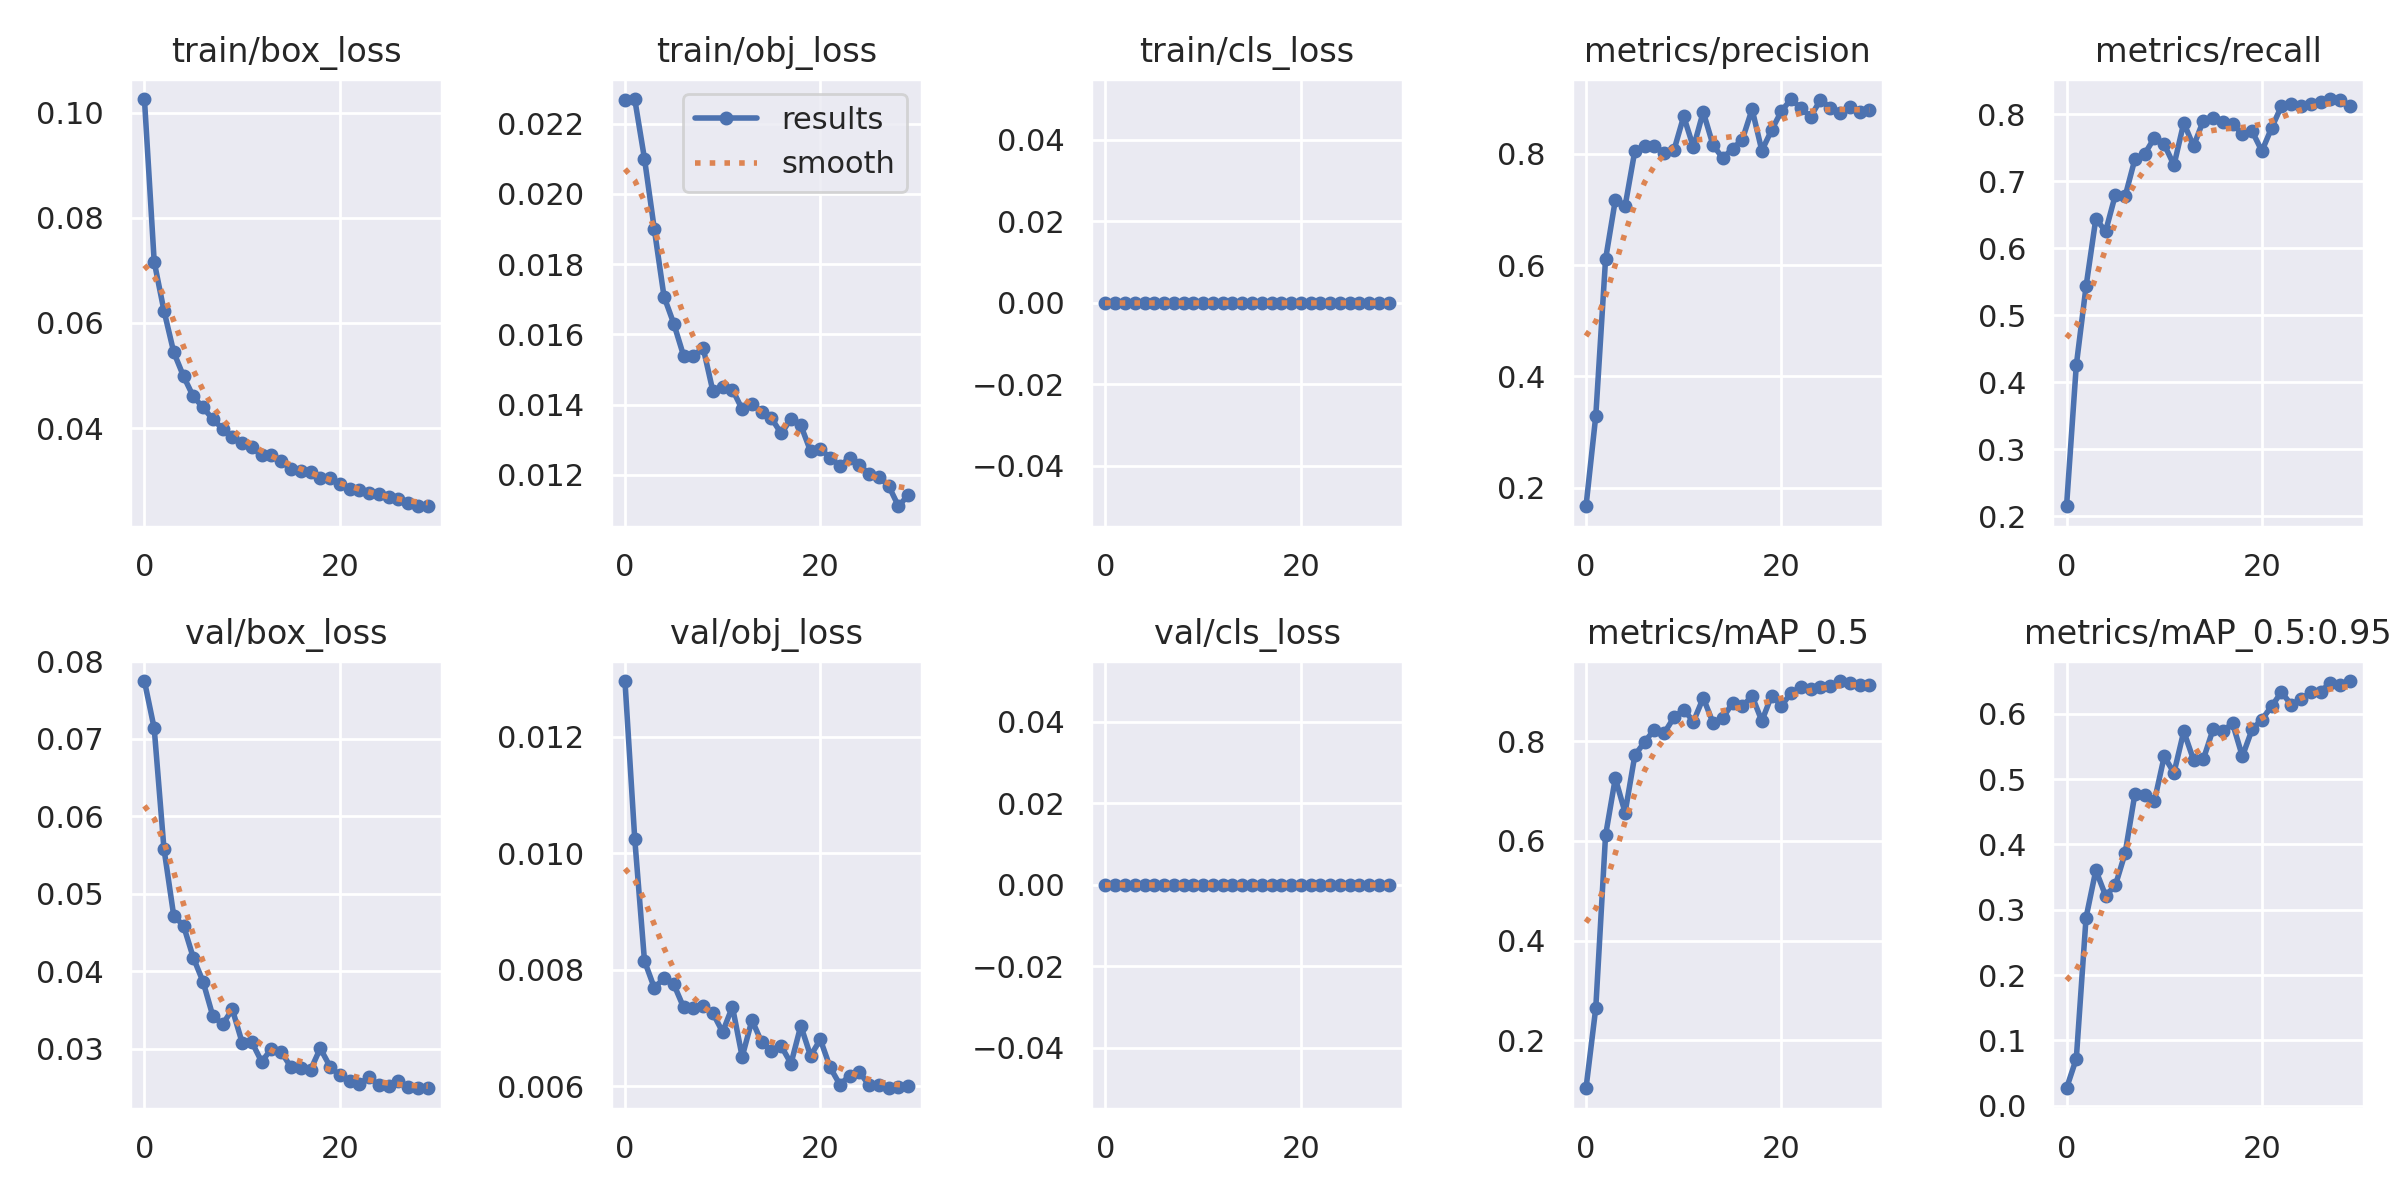

In [43]:
# evaluating the model
import utils
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results3/results.png')

augmented trainig data


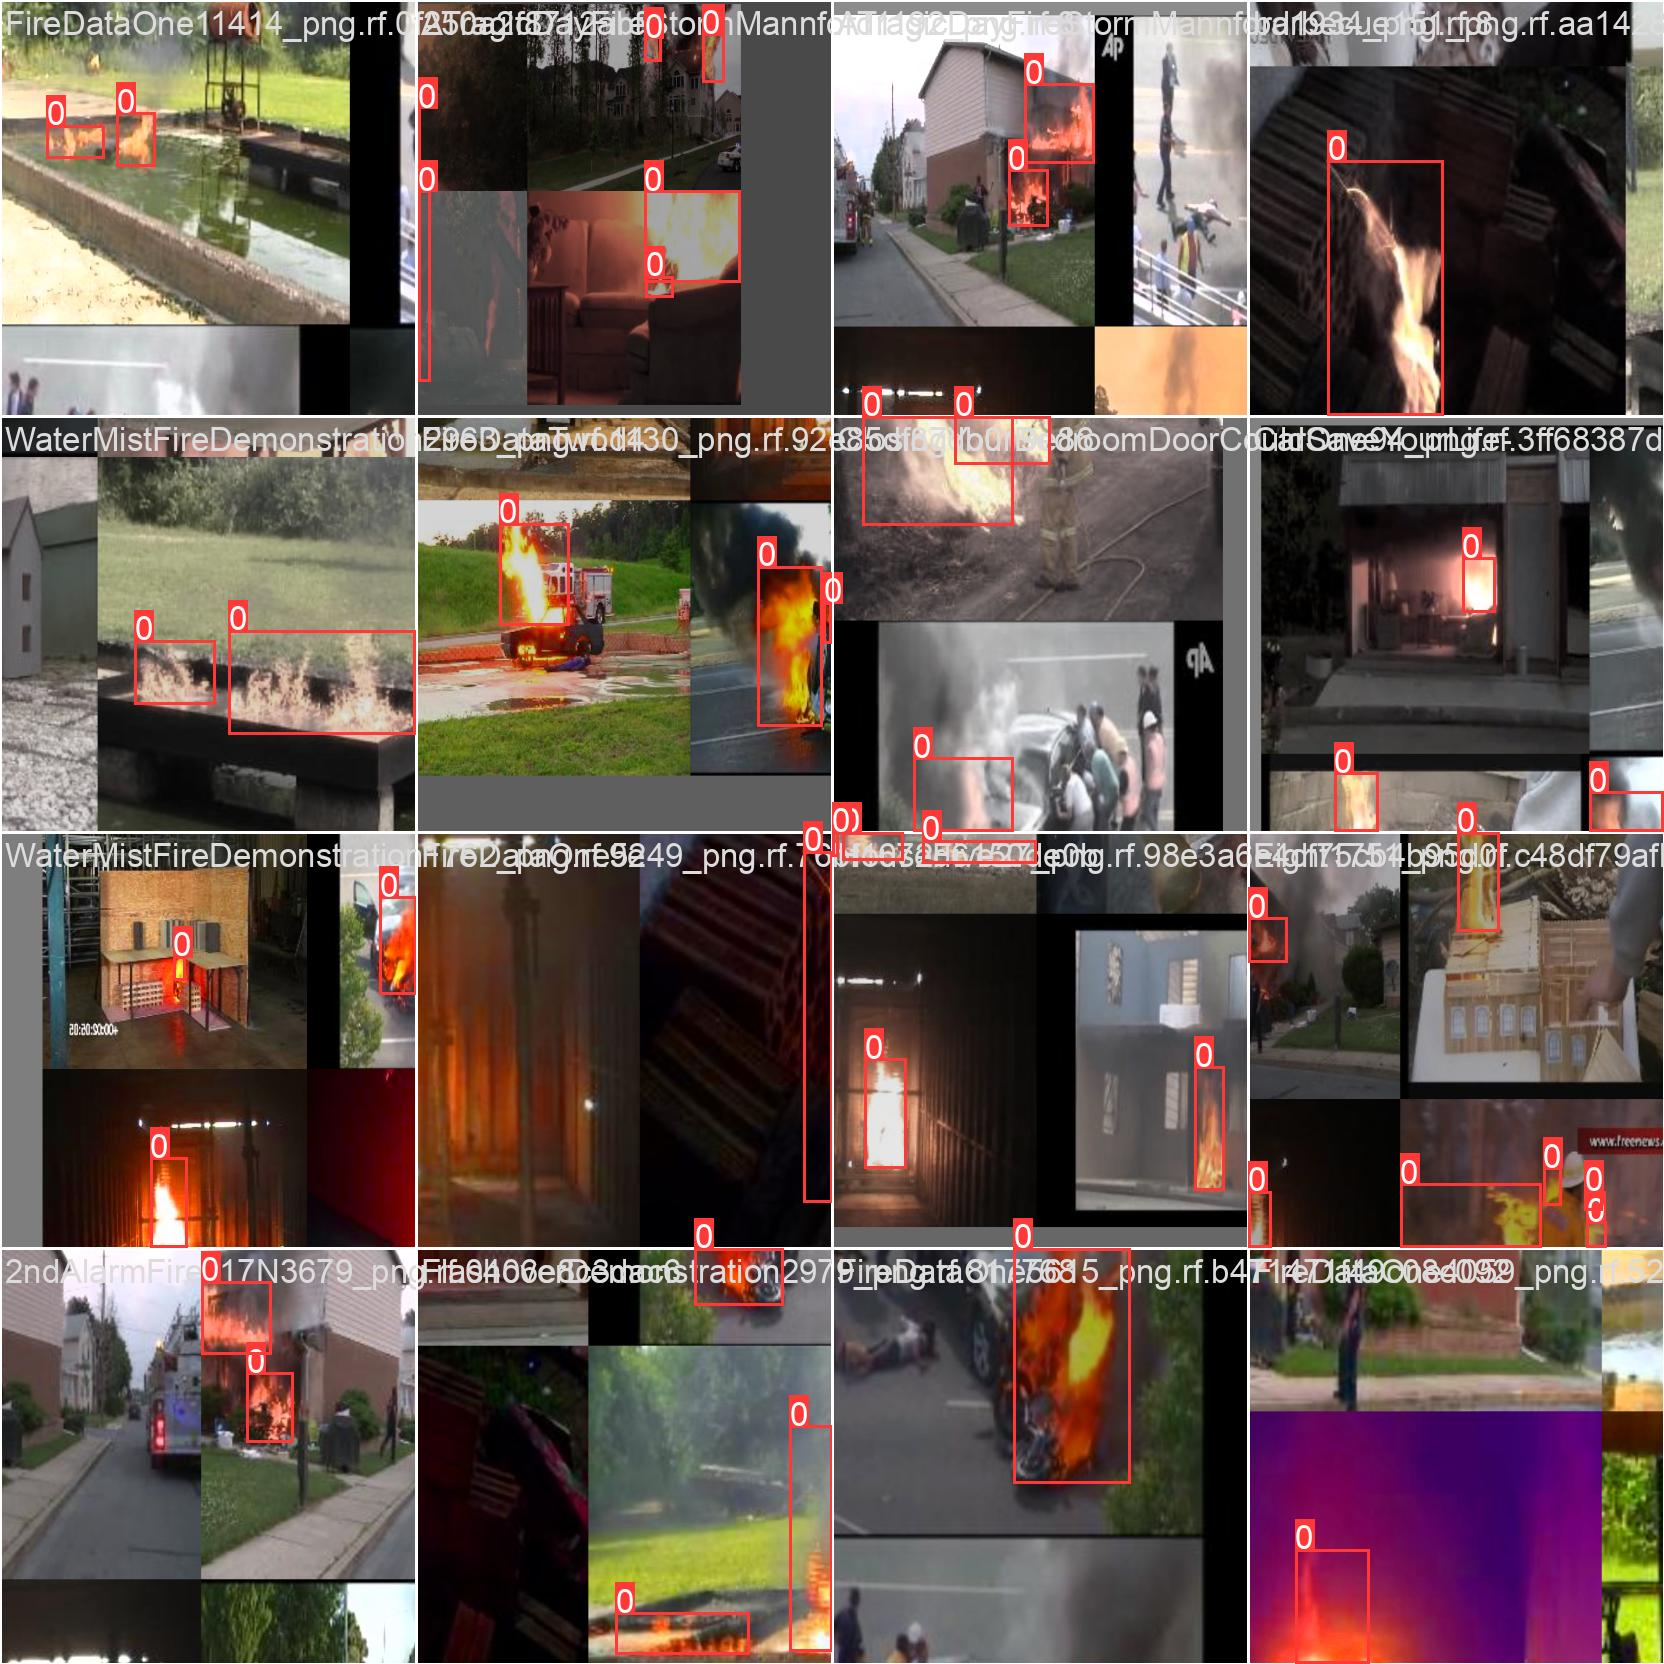

In [44]:
#printing images
print("augmented trainig data")
Image(filename = '/content/yolov5/runs/train/yolov5s_results3/train_batch0.jpg', width=1000)